## Event Classification

#### Import Packages

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import glob
import matplotlib.pyplot as plt
import numpy as np
import skimage.io as io

from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_val_predict, train_test_split, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.externals import joblib

#### Load Datasets

First we load the images from the label folders:

In [2]:
head_head = io.ImageCollection('../data/Dataset/head-head/*.jpg')
regular_encounter = io.ImageCollection('../data/Dataset/regular-encounter/*.jpg')

You can check if everything is alright by inspecting the first element of each image collection:

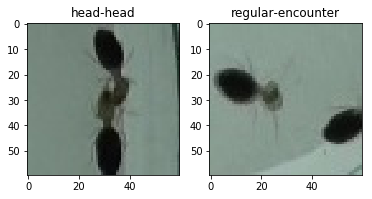

In [3]:
figure, axis = plt.subplots(1,2)

axis[0].imshow(head_head[0])
axis[0].set_title('head-head')
axis[1].imshow(regular_encounter[0])
axis[1].set_title('regular-encounter')

plt.show()

Now let's concatenate the images in a single matrix, our dataset:

In [4]:
dataset = io.ImageCollection.concatenate(np.vstack((head_head, regular_encounter)))
dataset.shape

(29520, 60, 60, 3)

And unroll each image as a single row in the dataset matrix:

In [5]:
dataset = dataset.reshape(dataset.shape[0], -1)
dataset.shape

(29520, 10800)

We also must create a target vector, containing the encoded class of each image:

In [6]:
targets = np.zeros(dataset.shape[0])
targets[:len(head_head)] = 0
targets[len(head_head):] = 1
targets.shape

(29520,)

Finally we have our examples and targets in separated, indexed arrays:

In [7]:
X, y = dataset, targets

We then shuffle the data:

In [8]:
shuffled_indices = np.random.permutation(dataset.shape[0])
X = X[shuffled_indices]
y = y[shuffled_indices]

And for later reporting purposes we separate a training and test sets, in a 80/20% ratio:

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train

array([[117, 134, 124, ..., 112, 129, 119],
       [134, 154, 143, ..., 125, 153, 141],
       [112, 129, 119, ..., 115, 132, 122],
       ...,
       [113, 131, 119, ..., 119, 135, 125],
       [ 40,  57,  51, ..., 121, 141, 130],
       [123, 143, 132, ...,  37,  59,  47]], dtype=uint8)

#### Training a Pilot Model

To check if learning algorithms are really capable of correctly classify the termites' interactions, first we decided to train a quick and dirty model, namely a random forest tree classifier:

In [10]:
classifier = RandomForestClassifier(random_state=42, n_jobs=-1)
shuffle_split = ShuffleSplit(n_splits=3, test_size=0.20, train_size=0.80, random_state=42)
scores = cross_val_score(estimator=classifier, X=X_train, y=y_train, cv=shuffle_split, n_jobs=-1)
scores

array([0.94242168, 0.9407282 , 0.94009314])

The model clearly was able to fit the dataset, so we took this as a indication to proceed.

#### Preprocessing Data

Many algorithms expect that the input dataset have zero mean and variance within the same order, and since these characteristics speed up the model convergence, we'll preprocess the data using mean normalization and feature scaling. We must keep the scaler object so it can be applied in new examples when predicting our events classes.


In [11]:
scaler = StandardScaler(with_mean=True, with_std=True).fit(X_train)
X_train = scaler.transform(X_train)

#### Select The Most Promising Model

Now we should try some models and see which is more promising:

- Random Forest Trees

In [12]:
rf_classifier = RandomForestClassifier(random_state=42)
shuffle_split = ShuffleSplit(n_splits=3, test_size=0.20, train_size=0.80, random_state=42)
scores = cross_val_score(estimator=rf_classifier, X=X_train, y=y_train, cv=shuffle_split, n_jobs=-1, scoring='f1')
print('Scores: ', scores)
print('Mean: ', scores.mean())
print('Standard deviation: ', scores.std())

Scores:  [0.96649548 0.96622437 0.9654333 ]
Mean:  0.9660510477498789
Standard deviation:  0.0004506169229052765


- Neural Networks

In [13]:
mlp_classifier = MLPClassifier(random_state=42)
shuffle_split = ShuffleSplit(n_splits=3, test_size=0.20, train_size=0.80, random_state=42)
scores = cross_val_score(estimator=mlp_classifier, X=X_train, y=y_train, cv=shuffle_split, n_jobs=-1, scoring='f1')
print('Scores: ', scores)
print('Mean: ', scores.mean())
print('Standard deviation: ', scores.std())

Scores:  [0.97385702 0.97179299 0.97237296]
Mean:  0.9726743229892145
Standard deviation:  0.0008691649229541493


- Support Vector Machines

In [14]:
svc_classifier = SVC(random_state=42)
shuffle_split = ShuffleSplit(n_splits=3, test_size=0.20, train_size=0.80, random_state=42)
scores = cross_val_score(estimator=svc_classifier, X=X_train, y=y_train, cv=shuffle_split, n_jobs=-1, scoring='f1')
print('Scores: ', scores)
print('Mean: ', scores.mean())
print('Standard deviation: ', scores.std())

Scores:  [0.97369703 0.97513879 0.975     ]
Mean:  0.9746119390186919
Standard deviation:  0.0006494157194346314


- K Neighbors

In [15]:
knn_classifier = KNeighborsClassifier()
shuffle_split = ShuffleSplit(n_splits=3, test_size=0.20, train_size=0.80, random_state=42)
scores = cross_val_score(estimator=knn_classifier, X=X_train, y=y_train, cv=shuffle_split, n_jobs=-1, scoring='f1')
print('Scores: ', scores)
print('Mean: ', scores.mean())
print('Standard deviation: ', scores.std())

Scores:  [0.97079482 0.97230694 0.97033846]
Mean:  0.9711467425005696
Standard deviation:  0.0008412740993060233


We can see that the models achieved very similar results, but differently than the others, neural networks can be further scaled with the addition of convolutional or block layers, so it is our model of choice.


#### Model Fine Tuning

Since we've selected our model, now we can fiddle with hyperparameters.

In [16]:
parameters = {
                "hidden_layer_sizes": [(100,), (300,), (500,)],
                "activation": ['relu', 'logistic'],
                "solver": ['sgd', 'adam'],
                "alpha": [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1],
                "learning_rate": ['constant', 'adaptive'],
                "max_iter": [100, 300, 500]
             }

In [17]:
random_search = RandomizedSearchCV(MLPClassifier(), parameters, n_iter=25, scoring='f1', random_state=42)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
          fit_params=None, iid=True, n_iter=25, n_jobs=1,
          param_distributions={'hidden_layer_sizes': [(100,), (300,), (500,)], 'learning_rate': ['constant', 'adaptive'], 'solver': ['sgd', 'adam'], 'activation': ['relu', 'logistic'], 'max_iter': [100, 300, 500], 'alpha': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='f1', verbose=0)

In [18]:
random_search.cv_results_

{'mean_fit_time': array([  51.89137006,  340.6829687 ,   67.86933057,  309.52832508,
         268.07335997, 2145.28114247,   44.31550574,  136.15344747,
         149.63080382,  242.67553258,   90.10589306,  244.13095864,
         304.44028799,   82.0243063 ,  212.41864125,  283.05657307,
         812.35609325, 3156.92314967,  234.46508447,  338.01064229,
        2129.43998837,  208.15853039,  269.91388965,  623.00492175,
        3403.37199855]),
 'mean_score_time': array([0.65116318, 0.31893373, 0.64492138, 0.93030858, 0.31555351,
        0.65087485, 0.31848033, 0.58336576, 0.58403254, 0.78467607,
        0.92250911, 0.79435674, 0.82308586, 0.32975864, 0.96424166,
        0.81133024, 0.34736721, 0.64045684, 0.84826835, 0.3154184 ,
        0.62980159, 0.8142399 , 0.65080643, 0.59462245, 0.94643156]),
 'mean_test_score': array([0.9548677 , 0.97571875, 0.96322772, 0.97551658, 0.97524358,
        0.9765541 , 0.96837828, 0.97352692, 0.97025854, 0.96649514,
        0.96461523, 0.96761816, 0.

In [19]:
random_search.best_estimator_

MLPClassifier(activation='logistic', alpha=0.3, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(300,), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

This gives us the best model in 25 iterations using random configurations of the selected hyperparameters:

In [20]:
choosen_model = random_search.best_estimator_
choosen_model

MLPClassifier(activation='logistic', alpha=0.3, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(300,), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

Now let's save it so we don't need to run this whole process again.

In [21]:
joblib.dump(choosen_model, 'choosen_model.pkl')

['choosen_model.pkl']

And a final report on the model performance:

In [22]:
y_predicted = choosen_model.predict(X_train)
print(classification_report(y_train, y_predicted, target_names=['regular_encouter', 'head_head']))

                  precision    recall  f1-score   support

regular_encouter       0.99      0.99      0.99      3403
       head_head       1.00      1.00      1.00     20213

     avg / total       1.00      1.00      1.00     23616



#### Evaluating Model on Test Set

Let's now check the performance of the model in data it hasn't previously seen and if everything looks fine, deploy it:

In [23]:
X_test = scaler.transform(X_test)
y_test_predicted = choosen_model.predict(X_test)
classification_report(y_test, y_test_predicted, target_names=['regular_encounter', 'head_head'])

'                   precision    recall  f1-score   support\n\nregular_encounter       0.91      0.82      0.86       893\n        head_head       0.97      0.98      0.98      5011\n\n      avg / total       0.96      0.96      0.96      5904\n'